# Marco del problema

El objetivo es predecir el precio del airbnb utilizando los datos disponibles.

En este caso, estamos hablando de un problema supervisado, ya que los datos están etiquetados para el entrenamiento. Al ser un problema de predicción, estamos ante un caso de regresión, concretamente, de regresión múltiple, ya que tenemos varias características para predecir el valor. Como solamente tenemos que predecir un valor, estamos hablando de una regresión univariante.

Al tratarse de un problema de regresión, tomaremos como medida de confianza el error cuadrático medio **RMSE**

# Carga de datos

Cargamos los datos del dataset usando Pandas, creamos una función para ello

In [ ]:
import pandas as pd
import os

# Carga el dataset y devuelve un dataframe de Pandas
def load_airbnb_dataset(ruta):
    csv_path = os.path.join(ruta, "airbnb-listings.csv")
    return pd.read_csv(csv_path, sep=';')

In [ ]:
housing = load_airbnb_dataset('datasets')
housing.head()

Al usar la instrucción **head** de Pandas, obtenemos una primera visión de los datos. 

Cada fila corresponde a un apartamento, la primera fila contiene los nombres de las columnas.

# Estructura de los datos

Con la instrucción **înfo** vemos una pequeña descripción de los datos.

In [ ]:
housing.info()

Vemos que tenemos un total de 89 variables y 14780 observaciones (muy pocas para los estándares de Machine Learning).

Hay variables, por ejemplo **Has Availability** que solo tiene 12 valores no nulos.

La variable a predecir **price** (de ahora en adelante **y**) tiene 14763 valores no nulos, por lo que hay 17 pisos sin precio.

Hay muchas variables de tipo **object**, al leer desde un CSV, es posible que san variables de texto.

Cuando hicimos el head, pudimos ver que la variable "Cancellation Policy" tiene valores repetitivos, por lo que podría ser categórica. Vamos a comprobar si hay más variables categóricas.

In [ ]:
# Mostrar el value counts de cada una de las variables para encontrar variables categóricas

for i in housing.columns:
    print(housing.loc[:,i].value_counts())

Vemos que las siguientes variables son categóricas:

- Host Response Time
- Property Type
- Room Type
- Bed Type
- Cancellation Policy

In [ ]:
print('Host Response Time:')
print(housing.loc[:,'Host Response Time'].value_counts())
print()
print('Property Type:')
print(housing.loc[:,'Property Type'].value_counts())
print()
print('Room Type:')
print(housing.loc[:,'Room Type'].value_counts())
print()
print('Bed Type:')
print(housing.loc[:,'Bed Type'].value_counts())
print()
print('Cancellation Policy:')
print(housing.loc[:,'Cancellation Policy'].value_counts())

Analizamos los valores numéricos:

In [ ]:
housing.describe()

Mostramos un histograma por cada variable numérica para seguir familiarizándonos con los datos

In [ ]:
# Histograma
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## ¿Distribución del precio?

Si nos fijamos en el histograma de nuestra variable objetivo, parece que no siga una distribución normal, vamos a comprobarlo:

In [ ]:
media = housing["Price"].mean()
mediana = housing["Price"].median()
moda = housing["Price"].mode()
desviacion = housing["Price"].std()

print("""
    Media: %d
    Mediana: %d
    Moda: %d
    Desviación: %d
""" % (media,mediana,moda, desviacion))

Tal y como apuntaba el histograma, al ser la mediana, media y moda distintas y al ser 72 la desviación típica, el precio no sigue una distribución normal.

### Kolmogorov-Smirnov
Por si quedan dudas, hacemos el test de Kolmogorov-Smirnov

In [ ]:
from scipy import stats

stats.kstest(housing["Price"].values, 'norm', args=(media, desviacion))

El test devuelve nulos, parece que en la variable precio hay algunos variables nulos, comprobamos que así es:

In [ ]:
import math
for i in housing['Price']:
    if math.isnan(i):
        print(i)

Generamos un nuevo dataframe sin nulos para poder hacer el test:

In [ ]:
housingNoNulos = housing[housing['Price'].notnull()]

from scipy import stats

stats.kstest(housingNoNulos["Price"].values, 'norm', args=(media, desviacion))

El p valor es 0, por lo tanto, no sigue una distribución normal

### Shapiro
Hago la prueba también con el test de Shapiro

In [ ]:
df5kvalores = housingNoNulos[:5000]
stats.shapiro(df5kvalores["Price"].values)

El pvalor sigue siendo 0

# Dividir dataset en test & train
Para evitar obtener datos nunca vistos, dividimos el dataframe en dos partes, una para entrenamiento, y otra para pruebas. Evitamos mirar en el conjunto de test para no tropezarnos con algún patrón en los datos y enfocar nuestro modelo erróneamente.

Importante establecer el parámetro **random_tate** (semilla) para poder replicar la separación siempre de la misma forma. Suelen hacerse auditorías al modelo, la semilla hace que podamos hacer pruebas siempre con la misma separación.

La librería Scikit-Learn tiene una buena función que se encarga de hacer la separación.

__Generamos los conjuntos de train y test con el dataset original (no con el que le hemos quitado los nulos a la variable objetivo)__

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

# Guardo en csv la separación
train_set.to_csv('./train.csv', sep=';', decimal='.', index=False)
test_set.to_csv('./test.csv', sep=';', decimal='.', index=False)

In [323]:
import pandas as pd
import os

pd.set_option('display.max_rows', 10)  # Fuerzo a que muestre todas las filas

# Leo desde el csv de train
train_set = pd.read_csv('./train.csv', sep=';', decimal='.')

# Visualizar datos para extraer información
Creo una copia de los datos de train para no perjudicar a la división original.

In [324]:
copTrain = train_set.copy()

## Visualizamos los datos geográficos

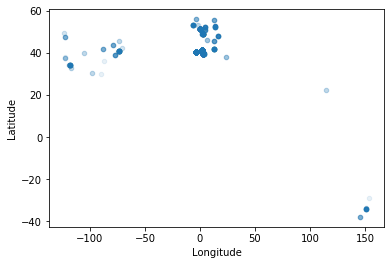

In [325]:
copTrain.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1)

Vemos, por la distribución geográfica, que la mayoría de datos están concentrados en Madrid, pero hay algunos erróneos, los de longitud negativa, pueden estar situados más o menos por UK.

# Mirando correlaciones
Calculamos el coeficiente de correlación entre la variable objetivo y el resto de variables:

In [326]:
matriz_corr = copTrain.corr()

matriz_corr["Price"].sort_values(ascending=False)

Price                1.000000
Weekly Price         0.838112
Monthly Price        0.828529
Cleaning Fee         0.677539
Accommodates         0.521981
                       ...   
ID                  -0.034661
Host ID             -0.053055
Number of Reviews   -0.058761
Scrape ID           -0.065973
Reviews per Month   -0.089032
Name: Price, Length: 36, dtype: float64

Vemos que hay mucha correlación entre el precio y el número de camas, o entre el precio y el número de huéspedes. Vemos también que la latitud o la longitud no tienen correlación, estas dos las excluiremos porque sabemos que no aportan información.

## Limpieza de datos inicial

Eliminamos algunas variables numéricas que sabemos que no son importantes para la creación del modelo:

In [327]:
columnasNoImport = ['Scrape ID', 'ID', 'Host ID', 'Longitude', 'Latitude', 'Host Listings Count', 'Host Total Listings Count', 'Calculated host listings count', 'Weekly Price', 'Monthly Price']

copTrain.drop(columnasNoImport, axis=1, inplace=True)

Analizamos la correlación entre el resto de variables:

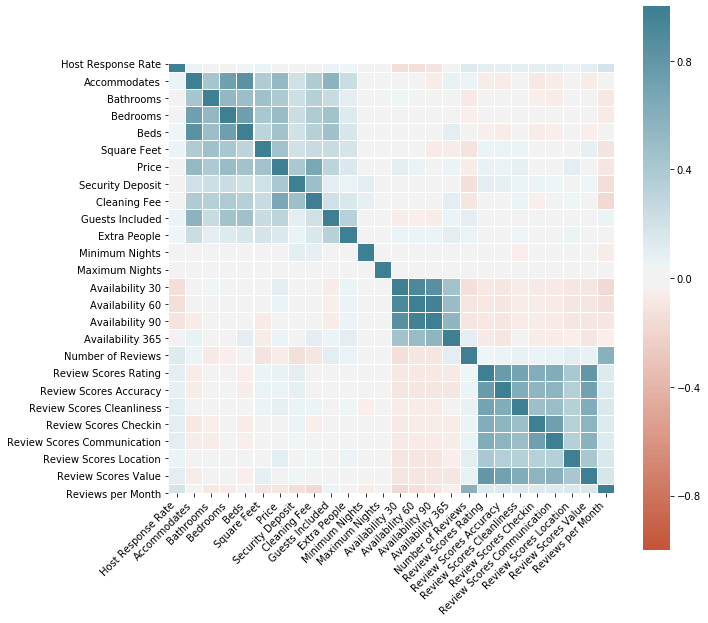

In [328]:
import seaborn as sns
import matplotlib.pyplot as plt

matriz_corr = copTrain.corr()

fig, ax = plt.subplots(figsize=(10,10))  # Tamaño

ax = sns.heatmap(
    matriz_corr, 
    vmin=-1, vmax=1, center=0,linewidths=.1,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Si nos fijamos más o menos en el centro, vemos que las variables Availability 30, 60 y 90 están altamente correladas, esto provoca una redundancia de datos, así que eliminamos estas variables:

In [329]:
copTrain.drop(['Availability 30', 'Availability 60', 'Availability 90'], axis=1, inplace=True)

# Combinación de variables
El precio medio por barrio puede ser una variable nueva interesante, al igual que el número de camas por dormitorios o el número de baños por cama.

In [330]:
# Número de camas por dormitorios
copTrain["beds_per_bedrooms"] = copTrain["Beds"] / copTrain["Bedrooms"]
copTrain["Bathrooms_per_bed"] = copTrain["Bathrooms"] / copTrain["Beds"]

# Volvemos a mirar la correlación
matriz_corr = copTrain.corr()
matriz_corr["Price"].sort_values(ascending=False)

Price                    1.000000
Cleaning Fee             0.677539
Accommodates             0.521981
Bedrooms                 0.505293
Square Feet              0.460604
                           ...   
Maximum Nights           0.000650
Review Scores Checkin   -0.004198
Number of Reviews       -0.058761
Reviews per Month       -0.089032
Bathrooms_per_bed       -0.200407
Name: Price, Length: 25, dtype: float64

Vemos que la variable bed_per_bedrooms no tiene apenas importancia, pero la variable Bathrooms_per_bed es más significativa con respecto al precio. Cuantos menos baños por cama hay, menor es el precio.

Mostramos de nuevo la matriz de correlación para ver cómo ha quedado después de las transformaciones que hemos hecho

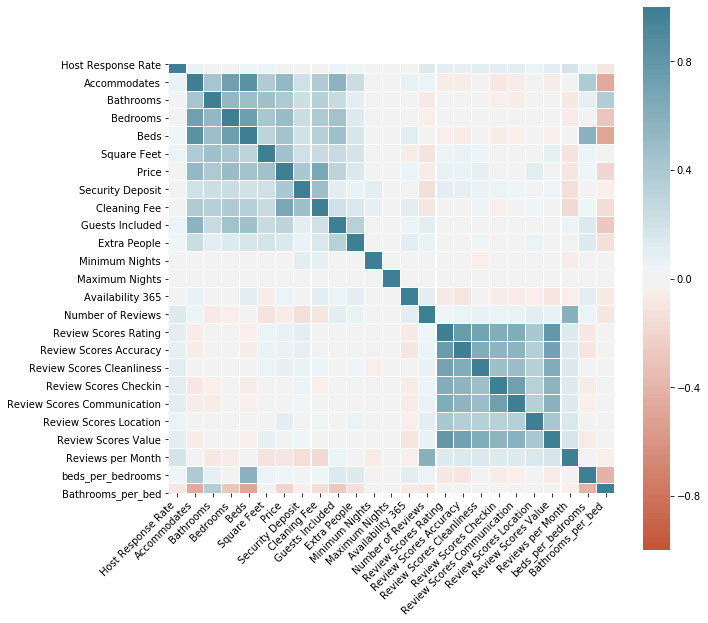

In [331]:
import seaborn as sns
import matplotlib.pyplot as plt

matriz_corr = copTrain.corr()

fig, ax = plt.subplots(figsize=(10,10))  # Tamaño

ax = sns.heatmap(
    matriz_corr, 
    vmin=-1, vmax=1, center=0,linewidths=.1,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Data cleaning
Vamos a analizar los valores de las variables no numéricas para eliminar las que no aporten información

In [332]:
import numpy as np
pd.set_option('display.max_columns', None)  # Fuerzo a que muestre todas las columnas
#copTrain.select_dtypes([np.number]).head()
copTrain.select_dtypes(exclude=[np.number]).head()

,Listing Url,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Property Type,Room Type,Bed Type,Amenities,Calendar Updated,Has Availability,Calendar last Scraped,First Review,Last Review,License,Jurisdiction Names,Cancellation Policy,Geolocation,Features
0,https://www.airbnb.com/rooms/8494011,2017-04-08,CITY CENTER LATINA B ROOM 2,"Se trata de un gran piso de diez habitaciones,...",Todas las camas del piso son de matrimonio. Se...,"Se trata de un gran piso de diez habitaciones,...",none,Se trata de una de las zonas más emblemáticas ...,NaN,El inquilino dispondrá de varias estaciones de...,Los inquilinos podrían acceder a todas las zon...,Estaremos siempre disponibles para cualquier d...,NaN,https://a0.muscache.com/im/pictures/107968260/...,https://a0.muscache.com/im/pictures/107968260/...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/107968260/...,https://www.airbnb.com/users/show/15258781,Erasmo´S,2014-05-08,"Madrid, Community of Madrid, Spain",Disfruta de tu habitación en el centro de Madr...,within a few hours,NaN,https://a0.muscache.com/im/users/15258781/prof...,https://a0.muscache.com/im/users/15258781/prof...,Justicia,"email,phone,reviews,work_email","La Latina, Madrid, Comunidad de Madrid 28012, ...",La Latina,Embajadores,Centro,Madrid,Comunidad de Madrid,28012,Madrid,"Madrid, Spain",ES,Spain,Apartment,Private room,Real Bed,"TV,Wireless Internet,Kitchen,Smoking allowed,D...",a week ago,NaN,2017-04-07,2016-06-29,2016-06-29,NaN,NaN,strict,"40.4102231405,-3.70867805612","Host Has Profile Pic,Is Location Exact,Require..."
1,https://www.airbnb.com/rooms/16865230,2017-04-08,Tu SUITE en el corazón de MALASAÑA,The apartment in Madrid has 1 bedrooms and has...,The apartment in Madrid has 1 bedrooms and has...,The apartment in Madrid has 1 bedrooms and has...,none,NaN,Optional services (not included in the price):...,NaN,NaN,NaN,1. Check-in schedule: From 01/01 to 31/12: eve...,https://a0.muscache.com/im/pictures/ececf49f-6...,https://a0.muscache.com/im/pictures/ececf49f-6...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/ececf49f-6...,https://www.airbnb.com/users/show/112373304,Daniel,2017-01-20,"Madrid, Community of Madrid, Spain","Deportista, amante del running y el fitness. E...",within a few hours,NaN,https://a0.muscache.com/im/pictures/65d3b194-8...,https://a0.muscache.com/im/pictures/65d3b194-8...,NaN,"email,phone,google,jumio,offline_government_id...","Madrid, Madrid 28004, Spain",NaN,Universidad,Centro,Madrid,Madrid,28004,Madrid,"Madrid, Spain",ES,Spain,Apartment,Entire home/apt,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",yesterday,NaN,2017-04-08,NaN,NaN,NaN,NaN,strict,"40.4272898629,-3.70437160544","Host Has Profile Pic,Host Identity Verified,Re..."
2,https://www.airbnb.com/rooms/9695108,2017-05-08,Room in amazing Kreuzberg-Neukoln,Renting my room at Weserstrasse during Christm...,NaN,Renting my room at Weserstrasse during Christm...,none,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/9555a3f6-c...,https://a0.muscache.com/im/pictures/9555a3f6-c...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/9555a3f6-c...,https://www.airbnb.com/users/show/22358988,Iván,2014-10-10,"Madrid, Community of Madrid, Spain",NaN,NaN,NaN,https://a0.muscache.com/im/pictures/eb280c8b-7...,https://a0.muscache.com/im/pictures/eb280c8b-7...,Neukölln,"email,phone,facebook,reviews,jumio","Neukölln, Berlin, Berlin 12045, Germany",Neukölln,Rixdorf,Neukölln,Berlin,Berlin,12045,Ber

In [333]:
# Borrar columnas no importantes
columnasNoImport = ['Listing Url', 'Last Scraped', 'Name', 'Summary', 'Space', 'Description', 'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host URL', 'Host Name', 'Host About', 'Host Thumbnail Url', 'Host Picture Url', 'Calendar last Scraped', 'Geolocation']

copTrain.drop(columnasNoImport, axis=1, inplace=True)

# Volvemos a mostrar las columnas no numéricas para seguir profundizando
copTrain.select_dtypes(exclude=[np.number]).head()

,Experiences Offered,Host Since,Host Location,Host Response Time,Host Acceptance Rate,Host Neighbourhood,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Property Type,Room Type,Bed Type,Amenities,Calendar Updated,Has Availability,First Review,Last Review,License,Jurisdiction Names,Cancellation Policy,Features
0,none,2014-05-08,"Madrid, Community of Madrid, Spain",within a few hours,NaN,Justicia,"email,phone,reviews,work_email","La Latina, Madrid, Comunidad de Madrid 28012, ...",La Latina,Embajadores,Centro,Madrid,Comunidad de Madrid,28012,Madrid,"Madrid, Spain",ES,Spain,Apartment,Private room,Real Bed,"TV,Wireless Internet,Kitchen,Smoking allowed,D...",a week ago,NaN,2016-06-29,2016-06-29,NaN,NaN,strict,"Host Has Profile Pic,Is Location Exact,Require..."
1,none,2017-01-20,"Madrid, Community of Madrid, Spain",within a few hours,NaN,NaN,"email,phone,google,jumio,offline_government_id...","Madrid, Madrid 28004, Spain",NaN,Universidad,Centro,Madrid,Madrid,28004,Madrid,"Madrid, Spain",ES,Spain,Apartment,Entire home/apt,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",yesterday,NaN,NaN,NaN,NaN,NaN,strict,"Host Has Profile Pic,Host Identity Verified,Re..."
2,none,2014-10-10,"Madrid, Community of Madrid, Spain",NaN,NaN,Neukölln,"email,phone,facebook,reviews,jumio","Neukölln, Berlin, Berlin 12045, Germany",Neukölln,Rixdorf,Neukölln,Berlin,Berlin,12045,Berlin,"Berlin, Germany",DE,Germany,Apartment,Private room,Real Bed,"Internet,Wireless Internet,Kitchen,Smoking all...",14 months ago,NaN,NaN,NaN,NaN,NaN,flexible,"Host Has Profile Pic,Host Identity Verified,Is..."
3,none,2017-02-23,"Madrid, Community of Madrid, Spain",NaN,NaN,Malasaña,"email,phone,facebook,google,jumio,offline_gove...","La Latina, Madrid, Comunidad de Madrid 28005, ...",La Latina,Palacio,Centro,Madrid,Comunidad de Madrid,28005,Madrid,"Madrid, Spain",ES,Spain,Apartment,Shared room,Real Bed,"TV,Wireless Internet,Kitchen,Elevator in build...",yesterday,NaN,NaN,NaN,NaN,NaN,strict,"Host Has Profile Pic,Host Identity Verified,Is..."
4,none,2014-05-24,"Madrid, Community of Madrid, Spain",within an hour,NaN,NaN,"email,phone,facebook,reviews","Santanyí, Balearic Islands 07660, Spain",NaN,Santanyí,NaN,Santanyí,Balearic Islands,07660,Mallorca Island,"Santanyí, Spain",ES,Spain,Apartment,Entire home/apt,Real Bed,"Kitchen,Free parking on premises,Smoking allow...",today,NaN,2016-06-24,2017-01-16,NaN,NaN,strict,"Host Has Profile Pic,Is Location Exact,Require..."


Si observamos la variable Features, vemos que podemos sacar alguna columna a partir de ella, que puede ser importante para el modelo. Creamos una lambda para generar nuevas columnas y después eliminamos la original.

In [334]:
# Analizar si hay valores vacíos
pd.set_option('display.max_rows', None)  
print(copTrain.loc[:,'Features'].value_counts())
pd.set_option('display.max_rows', 10)  

Host Has Profile Pic,Host Identity Verified,Is Location Exact,Requires License                                                                                                      2006
Host Has Profile Pic,Is Location Exact,Requires License                                                                                                                             1698
Host Has Profile Pic,Host Identity Verified,Is Location Exact,Requires License,Instant Bookable                                                                                     1417
Host Has Profile Pic,Host Identity Verified,Requires License                                                                                                                        1152
Host Has Profile Pic,Requires License                                                                                                                                               1118
Host Has Profile Pic,Is Location Exact,Requires License,Instant Bookable   

In [335]:
# Vamos a ver antes los valores únicos que hay para saber qué columnas tenemos que crear y depaso eliminamos los nan
listaFeatures = []

for x in  copTrain["Features"].dropna().unique():
    for y in str(x).split(","):    
        if y not in listaFeatures:
            listaFeatures.append(y)

listaFeatures

['Host Has Profile Pic',
 'Is Location Exact',
 'Requires License',
 'Host Identity Verified',
 'Instant Bookable',
 'Host Is Superhost',
 'Require Guest Profile Picture',
 'Require Guest Phone Verification']

In [336]:
def getNewColumnFromFeature(pTexToSearch, pList):
    if pTexToSearch in str(pList).split(","):        
        return 1
    else:
        return 0

for i in listaFeatures:
    copTrain[i] = copTrain["Features"].apply(lambda x: getNewColumnFromFeature(i, x))    

copTrain.drop(['Features'], axis=1, inplace=True)

In [337]:
copTrain

,Experiences Offered,Host Since,Host Location,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Neighbourhood,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 365,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Reviews per Month,beds_per_bedrooms,Bathrooms_per_bed,Host Has Profile Pic,Is Location Exact,Requires License,Host Identity Verified,Instant Bookable,Host Is Superhost,Require Guest Profile Picture,Require Guest Phone Verification
0,none,2014-05-08,"Madrid, Community of Madrid, Spain",within a few hours,100.0,NaN,Justicia,"email,phone,reviews,work_email","La Latina, Madrid, Comunidad de Madrid 28012, ...",La Latina,Embajadores,Centro,Madrid,Comunidad de Madrid,28012,Madrid,"Madrid, Spain",ES,Spain,Apartment,Private room,2,4.0,1.0,1.0,Real Bed,"TV,Wireless Internet,Kitchen,Smoking allowed,D...",NaN,20.0,NaN,15.0,1,5,10,1125,a week ago,NaN,52,1,2016-06-29,2016-06-29,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,strict,0.11,1.0,4.000000,1,1,1,0,0,0,0,0
1,none,2017-01-20,"Madrid, Community of Madrid, Spain",within a few hours,100.0,NaN,NaN,"email,phone,google,jumio,offline_government_id...","Madrid, Madrid 28004, Spain",NaN,Universidad,Centro,Madrid,Madrid,28004,Madrid,"Madrid, Spain",ES,Spain,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",NaN,86.0,250.0,15.0,2,5,1,1125,yesterday,NaN,260,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,NaN,2.0,0.500000,1,0,1,1,1,0,0,0
2,none,2014-10-10,"Madrid, Community of Madrid, Spain",NaN,NaN,NaN,Neukölln,"email,phone,facebook,reviews,jumio","Neukölln, Berlin, Berlin 12045, Germany",Neukölln,Rixdorf,Neukölln,Berlin,Berlin,12045,Berlin,"Berlin, Germany",DE,Germany,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"Internet,Wireless Internet,Kitchen,Smoking all...",NaN,66.0,NaN,24.0,1,0,3,1125,14 months ago,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,1.0,1.000000,1,1,0,1,0,0,0,0
3,none,2017-02-23,"Madrid, Community of Madrid, Spain",NaN,NaN,NaN,Malasaña,"email,phone,facebook,google,jumio,offline_gove...","La Latina, Madrid, Comunidad de Madrid 28005, ...",La Latina,Palacio,Centro,Madrid,Comunidad de Madrid,28005,Madrid,"Madrid, Spain",ES,Spain,Apartment,Shared room,1,2.0,1.0,1.0,Real Bed,"TV,Wireless Internet,Kitchen,Elevator in build...",NaN,30.0,200.0,30.0,1,0,7,1125,yesterday,NaN,280,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,NaN,1.0,2.000000,1,1,1,1,0,0,0,0
4,none,2014-05-24,"Madrid, Community of Madrid, Spain",within an hour,100.0,NaN,NaN,"email,phone,facebook,reviews","Santanyí, Balearic Islands 07660, Spain",NaN,Santanyí,NaN,Santanyí,Balearic Islands,07660,Mallorca Island,"Santanyí, Spain",ES,Spain,Apartment,Entire home/apt,2,1.0,1.0,2.0,Real Bed,"Kitchen,Free parking on premises,Smoking allow...",NaN,100.0,300.0,NaN,1,0,4,1125,today,NaN,264,14,2016-06-24,2017-01-16,92.0,10.0,9.0,10.0,10.0,10.0,9.0,NaN,NaN,strict,1.58,2.0,0.500000,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11819,none,2014-07-01,"Madrid, Community of Madrid, Spain",within an hour,100.0,NaN,NaN,"email,phone,facebook,reviews","Madrid, Comunidad de Madrid 28002, Spain",NaN,Ciudad Jardín,Chamartín,Madrid,Comunidad de Madrid,28002,Madrid,"Madrid, Spain",ES,Spain,Apartment

In [338]:
# Analizar si hay valores vacíos
pd.set_option('display.max_rows', None)  
print(copTrain.loc[:,'Amenities'].value_counts())
pd.set_option('display.max_rows', 10)  

ernet,Air conditioning,Kitchen,Elevator in building,Heating,Family/kid friendly,Washer,Fire extinguisher,Essentials,Hangers,Iron,translation missing: en.hosting_amenity_50                                                                                                                                                                                                                                                                                                                                                                                               1
TV,Internet,Wireless Internet,Kitchen,Free parking on premises,Pets allowed,Indoor fireplace,Heating,Family/kid friendly,Washer,Dryer                                                                                                                                                                                                                                                                                                                       

Las variables Amenities y Host Verifications tienen la misma casuística que la variable Features

In [339]:
listaAmenities = []

for x in  copTrain["Amenities"].dropna().unique():
    for y in str(x).split(","):    
        if y not in listaAmenities:
            listaAmenities.append(y)

listaAmenities

['TV',
 'Wireless Internet',
 'Kitchen',
 'Smoking allowed',
 'Doorman',
 'Buzzer/wireless intercom',
 'Heating',
 'Washer',
 'Hangers',
 'translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50',
 'Internet',
 'Air conditioning',
 'Elevator in building',
 'Dryer',
 'Essentials',
 '24-hour check-in',
 'Hair dryer',
 'Iron',
 'Lock on bedroom door',
 'Laptop friendly workspace',
 'Free parking on premises',
 'Family/kid friendly',
 'Private living room',
 'Pets allowed',
 'Pets live on this property',
 'Cable TV',
 'Smoke detector',
 'Carbon monoxide detector',
 'Shampoo',
 'Self Check-In',
 'Doorman Entry',
 'Indoor fireplace',
 'Safety card',
 'Wheelchair accessible',
 'Breakfast',
 'Fire extinguisher',
 'Bathtub',
 'Suitable for events',
 'Dog(s)',
 'First aid kit',
 'Private entrance',
 'Pool',
 'Hot tub',
 'Other pet(s)',
 'Cat(s)',
 'Room-darkening shades',
 'Lockbox',
 'Window guards',
 'Babysitter recommendations',
 'Crib',
 'Elevator in Buildin

In [340]:
# Analizar si hay valores vacíos
pd.set_option('display.max_rows', None)  
print(copTrain.loc[:,'Host Verifications'].value_counts())
pd.set_option('display.max_rows', 10)  

ent_id                                                               173
email,phone,reviews,manual_offline,jumio                                                                     134
phone                                                                                                        132
phone,reviews                                                                                                119
email,phone,facebook                                                                                         112
email,phone,facebook,reviews,jumio,work_email                                                                108
email,phone,facebook,reviews,jumio,offline_government_id,government_id                                       108
email,phone,google,reviews,jumio                                                                              76
email,phone,reviews,manual_offline                                                                            66
email,phone,google,revi

In [341]:
listaHost = []

for x in  copTrain["Host Verifications"].dropna().unique():
    for y in str(x).split(","):    
        if y not in listaHost:
            listaHost.append(y)

listaHost

['email',
 'phone',
 'reviews',
 'work_email',
 'google',
 'jumio',
 'offline_government_id',
 'government_id',
 'facebook',
 'linkedin',
 'manual_offline',
 'selfie',
 'identity_manual',
 'sent_id',
 'kba',
 'manual_online',
 'photographer',
 'None',
 'weibo',
 'amex']

In [342]:
for i in listaAmenities:
    copTrain[i] = copTrain["Amenities"].apply(lambda x: getNewColumnFromFeature(i, x))    

copTrain.drop(['Amenities'], axis=1, inplace=True)

for i in listaHost:
    copTrain[i] = copTrain["Host Verifications"].apply(lambda x: getNewColumnFromFeature(i, x))    

copTrain.drop(['Host Verifications'], axis=1, inplace=True)

In [343]:
copTrain

,Experiences Offered,Host Since,Host Location,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Neighbourhood,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Square Feet,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 365,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Reviews per Month,beds_per_bedrooms,Bathrooms_per_bed,Host Has Profile Pic,Is Location Exact,Requires License,Host Identity Verified,Instant Bookable,Host Is Superhost,Require Guest Profile Picture,Require Guest Phone Verification,TV,Wireless Internet,Kitchen,Smoking allowed,Doorman,Buzzer/wireless intercom,Heating,Washer,Hangers,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,Internet,Air conditioning,Elevator in building,Dryer,Essentials,24-hour check-in,Hair dryer,Iron,Lock on bedroom door,Laptop friendly workspace,Free parking on premises,Family/kid friendly,Private living room,Pets allowed,Pets live on this property,Cable TV,Smoke detector,Carbon monoxide detector,Shampoo,Self Check-In,Doorman Entry,Indoor fireplace,Safety card,Wheelchair accessible,Breakfast,Fire extinguisher,Bathtub,Suitable for events,Dog(s),First aid kit,Private entrance,Pool,Hot tub,Other pet(s),Cat(s),Room-darkening shades,Lockbox,Window guards,Babysitter recommendations,Crib,Elevator in Building,Smoke Detector,Carbon Monoxide Detector,Gym,Free Parking on Premises,Safety Card,Fire Extinguisher,Hot Tub,Laptop Friendly Workspace,Pack ’n Play/travel crib,Smoking Allowed,Indoor Fireplace,Family/Kid Friendly,First Aid Kit,High chair,Keypad,Game console,Smartlock,Outlet covers,Children’s books and toys,Baby bath,Table corner guards,Air Conditioning,24-Hour Check-in,Hair Dryer,Buzzer/Wireless Intercom,Children’s dinnerware,Pets Allowed,Paid parking off premises,Stair gates,Wheelchair Accessible,Washer / Dryer,Hot water,Bed linens,Extra pillows and blankets,Microwave,Coffee maker,Refrigerator,Dishwasher,Dishes and silverware,Cooking basics,Oven,Patio or balcony,Garden or backyard,Luggage dropoff allowed,Long term stays allowed,Path to entrance lit at night,Changing table,Free parking on street,Lock on Bedroom Door,EV charger,BBQ grill,Suitable for Events,Fireplace guards,email,phone,reviews,work_email,google,jumio,offline_government_id,government_id,facebook,linkedin,manual_offline,selfie,identity_manual,sent_id,kba,manual_online,photographer,None,weibo,amex
0,none,2014-05-08,"Madrid, Community of Madrid, Spain",within a few hours,100.0,NaN,Justicia,"La Latina, Madrid, Comunidad de Madrid 28012, ...",La Latina,Embajadores,Centro,Madrid,Comunidad de Madrid,28012,Madrid,"Madrid, Spain",ES,Spain,Apartment,Private room,2,4.0,1.0,1.0,Real Bed,NaN,20.0,NaN,15.0,1,5,10,1125,a week ago,NaN,52,1,2016-06-29,2016-06-29,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,strict,0.11,1.0,4.000000,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,none,2017-01-20,"Madrid, Community of Madrid, Spain",within a few hours,100.0,NaN,NaN,"Madrid, Madrid 28004, Spain",NaN,Universidad,Centro,Madrid,Madrid,28004,Madrid,"Madrid, Spain",ES,Spain,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,NaN,86.0,250.0,15.0,2,5,1,1125,yesterday,NaN,260,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,NaN,2.0,0.500000,1,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [344]:
pd.set_option('display.max_rows', None)  

for i in listaAmenities:
    print(copTrain.loc[:,i].value_counts())

pd.set_option('display.max_rows', 20)

1    9267
0    2557
Name: TV, dtype: int64
1    11078
0      746
Name: Wireless Internet, dtype: int64
1    10891
0      933
Name: Kitchen, dtype: int64
0    8719
1    3105
Name: Smoking allowed, dtype: int64
0    9743
1    2081
Name: Doorman, dtype: int64
0    6564
1    5260
Name: Buzzer/wireless intercom, dtype: int64
1    10638
0     1186
Name: Heating, dtype: int64
1    10013
0     1811
Name: Washer, dtype: int64
1    7760
0    4064
Name: Hangers, dtype: int64
0    9053
1    2771
Name: translation missing: en.hosting_amenity_49, dtype: int64
0    8364
1    3460
Name: translation missing: en.hosting_amenity_50, dtype: int64
1    6708
0    5116
Name: Internet, dtype: int64
1    6403
0    5421
Name: Air conditioning, dtype: int64
1    6860
0    4964
Name: Elevator in building, dtype: int64
0    9573
1    2251
Name: Dryer, dtype: int64
1    10139
0     1685
Name: Essentials, dtype: int64
0    9000
1    2824
Name: 24-hour check-in, dtype: int64
1    6559
0    5265
Name: Hair dryer, dtyp

Las siguientes columnas no son significativas bien por tener casi todos los valores en 1 o bien porque todos los valores sean iguales, las borramos

In [345]:
columnasNoImport = ['Other pet(s)','Room-darkening shades','Lockbox','Window guards','Babysitter recommendations','Crib','Elevator in Building','Smoke Detector','Carbon Monoxide Detector','Free Parking on Premises','Safety Card','Fire Extinguisher','Hot Tub','Laptop Friendly Workspace','Pack ’n Play/travel crib','Smoking Allowed','Indoor Fireplace','Family/Kid Friendly','First Aid Kit','High chair','Keypad','Game console','Smartlock','Outlet covers','Children’s books and toys','Baby bath','Table corner guards','Air Conditioning','24-Hour Check-in','Hair Dryer','Buzzer/Wireless Intercom','Children’s dinnerware','Pets Allowed','Paid parking off premises','Stair gates','Wheelchair Accessible','Washer / Dryer','Hot water','Bed linens','Extra pillows and blankets','Microwave','Coffee maker','Refrigerator','Dishwasher','Dishes and silverware','Cooking basics','Oven','Patio or balcony','Garden or backyard','Luggage dropoff allowed','Long term stays allowed','Path to entrance lit at night','Changing table','Free parking on street','Lock on Bedroom Door','EV charger','BBQ grill','Suitable for Events','Fireplace guards']

copTrain.drop(columnasNoImport, axis=1, inplace=True)

In [346]:
pd.set_option('display.max_rows', None)  

for i in listaHost:
    print(copTrain.loc[:,i].value_counts())

pd.set_option('display.max_rows', 20)

1    11433
0      391
Name: email, dtype: int64
1    11712
0      112
Name: phone, dtype: int64
1    10747
0     1077
Name: reviews, dtype: int64
0    10811
1     1013
Name: work_email, dtype: int64
0    11091
1      733
Name: google, dtype: int64
1    6844
0    4980
Name: jumio, dtype: int64
0    11177
1      647
Name: offline_government_id, dtype: int64
0    9691
1    2133
Name: government_id, dtype: int64
0    9344
1    2480
Name: facebook, dtype: int64
0    11609
1      215
Name: linkedin, dtype: int64
0    11481
1      343
Name: manual_offline, dtype: int64
0    11795
1       29
Name: selfie, dtype: int64
0    11796
1       28
Name: identity_manual, dtype: int64
0    11785
1       39
Name: sent_id, dtype: int64
0    11716
1      108
Name: kba, dtype: int64
0    11738
1       86
Name: manual_online, dtype: int64
0    11822
1        2
Name: photographer, dtype: int64
0    11822
1        2
Name: None, dtype: int64
0    11823
1        1
Name: weibo, dtype: int64
0    11819
1        5


In [347]:
columnasNoImport = ['manual_offline','selfie','identity_manual','sent_id','photographer','None','weibo','amex']
copTrain.drop(columnasNoImport, axis=1, inplace=True)

Vemos que la columna Street, en muchos de los casos no es la calle del apartamento, también tenemos variables como Neighbourhood, Neighbourhood Cleansed, Neighbourhood Group Cleansed, City, Market, State, Smart Location y Zipcode que muestran más o menos la misma información. Country Code, Country asumimos que será España porque estamoa analizando el precio en Madrid.

De momento las eliminamos todas menos City y ZipCode que analizaremos para ver cuál tiene mejor información.

In [348]:
columnasNoImport = ['Street', 'Neighbourhood', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'State', 'Market', 'Smart Location', 'Country Code', 'Country']

copTrain.drop(columnasNoImport, axis=1, inplace=True)
copTrain

,Experiences Offered,Host Since,Host Location,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Neighbourhood,City,Zipcode,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Square Feet,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 365,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Reviews per Month,beds_per_bedrooms,Bathrooms_per_bed,Host Has Profile Pic,Is Location Exact,Requires License,Host Identity Verified,Instant Bookable,Host Is Superhost,Require Guest Profile Picture,Require Guest Phone Verification,TV,Wireless Internet,Kitchen,Smoking allowed,Doorman,Buzzer/wireless intercom,Heating,Washer,Hangers,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,Internet,Air conditioning,Elevator in building,Dryer,Essentials,24-hour check-in,Hair dryer,Iron,Lock on bedroom door,Laptop friendly workspace,Free parking on premises,Family/kid friendly,Private living room,Pets allowed,Pets live on this property,Cable TV,Smoke detector,Carbon monoxide detector,Shampoo,Self Check-In,Doorman Entry,Indoor fireplace,Safety card,Wheelchair accessible,Breakfast,Fire extinguisher,Bathtub,Suitable for events,Dog(s),First aid kit,Private entrance,Pool,Hot tub,Cat(s),Gym,email,phone,reviews,work_email,google,jumio,offline_government_id,government_id,facebook,linkedin,kba,manual_online
0,none,2014-05-08,"Madrid, Community of Madrid, Spain",within a few hours,100.0,NaN,Justicia,Madrid,28012,Apartment,Private room,2,4.0,1.0,1.0,Real Bed,NaN,20.0,NaN,15.0,1,5,10,1125,a week ago,NaN,52,1,2016-06-29,2016-06-29,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,strict,0.11,1.0,4.000000,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0
1,none,2017-01-20,"Madrid, Community of Madrid, Spain",within a few hours,100.0,NaN,NaN,Madrid,28004,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,NaN,86.0,250.0,15.0,2,5,1,1125,yesterday,NaN,260,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,NaN,2.0,0.500000,1,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0
2,none,2014-10-10,"Madrid, Community of Madrid, Spain",NaN,NaN,NaN,Neukölln,Berlin,12045,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,66.0,NaN,24.0,1,0,3,1125,14 months ago,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,1.0,1.000000,1,1,0,1,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,1,0,0,0
3,none,2017-02-23,"Madrid, Community of Madrid, Spain",NaN,NaN,NaN,Malasaña,Madrid,28005,Apartment,Shared room,1,2.0,1.0,1.0,Real Bed,NaN,30.0,200.0,30.0,1,0,7,1125,yesterday,NaN,280,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,NaN,1.0,2.000000,1,1,1,1,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,1,0,0,0
4,none,2014-05-24,"Madrid, Community of Madrid, Spain",within an hour,100.0,NaN,NaN,Santanyí,07660,Apartment,Entire home/apt,2,1.0,1.0,2.0,Real Bed,NaN,100.0,300.0,NaN,1,0,4,1125,today,NaN,264,14,2016-06-24,2017-01-16,92.0,10.0,9.0,10.0,10.0,10.0,9.0,NaN,NaN,strict,1.58,2.0,0.500000,1,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [349]:
# Analizamos los valores únicos de City
copTrain["City"].sort_values(ascending=False).unique()

array(['马德里', '馬德里', 'villa verde bajo', 'madrid', 'las matas  madrid',
       'Woolloomooloo', 'Windsor', 'Wien', 'Westmount', 'West Hollywood',
       'Washington', 'Vilafranca de Bonany', 'Vienna', 'Venice',
       'Venezia', 'Vancouver', 'Vallgornera', 'Valldemossa',
       'Valderrodrigo', 'Urbanització Montferrutx', 'Tsim Sha Tsui',
       'Torrenova', 'Toronto', 'Topanga', 'Templeogue', 'Sóller',
       'Sutton', 'Surry Hills', 'St Peters', 'South Yarra', 'Son Vida',
       'Son Veri Nou , Llucmajor', 'Son Servera', 'Son Moll',
       'Sol de Mallorca', 'Sineu', 'Ses Salines', 'Sencelles', 'Selva',
       'Seattle', 'Schaerbeek', 'Santanyí', 'Santa Monica',
       'Santa Maria del Camí', 'Santa Margalida',
       'Sant Llorenç des Cardassar', 'Sant Joan', 'San Lázaro',
       'San Francisco', 'San Fernando de Henares', 'San Fernando',
       'San Diego', 'Salerno', 'Saint-Josse-ten-Noode', 'Saint-Gilles',
       'Sa Pobla', 'Sa Coma', 'Rotes Velles', 'Rome', 'Roma', 'Richmond',


In [350]:
# Borramos todas las filas que no correspondan a Madrid
copTrain = copTrain[copTrain['City'] == 'Madrid']

In [351]:
copTrain["Zipcode"].sort_values(ascending=False).unique()

array(['28850', '2815', '28105', '28094', '28060', '28058', '28056',
       '28055', '28054', '28053', '28052', '28051\n28051', '28051',
       '28050', '2805', '28049', '28047', '28046', '28045', '28044',
       '28043', '28042', '28041', '28040', '2804', '28039', '28038',
       '28037', '28036', '28035', '28034', '28033', '28032', '28031',
       '28030', '28029', '28028', '28027', '28026', '28025', '28024',
       '28023', '28022', '28021', '28020', '28019', '28018', '28017',
       '28016', '28015', '28014', '28013', '28012', '28011', '28010',
       '28009', '28008', '28007', '28006', '28005', '28004', '28003',
       '28002\n28002', '28002', '280013', '28001', '28', '27013', '27004',
       '25008', '2015', '20126', '20013', '-', nan], dtype=object)

Vemos que hay algunos valores que no tienen sentido, analizamos el impacto de esos valores:

In [352]:
pd.set_option('display.max_rows', None)  # Fuerzo a que muestre todas las filas
print(copTrain.loc[:,'Zipcode'].value_counts())

28012           1641
28004           1458
28005            967
28013            804
28014            489
28015            473
28045            410
28010            312
28008            272
28028            204
28011            191
28006            186
28001            182
28009            177
28019            165
28007            163
28020            148
28002            142
28003            142
28039            130
28025             97
28027             96
28017             91
28029             86
28043             80
28026             75
28042             71
28053             68
28033             68
28038             64
28030             62
28016             61
28047             58
28036             56
28041             53
28021             52
28050             47
28037             47
28035             44
28034             38
28024             34
28018             34
28046             24
28022             23
28031             22
28032             21
28023             17
28044        

Vemos que los valores erróneos no son significativos, por tanto, borramos todos los que tengan longitud distinta de 5

In [353]:
copTrain = copTrain[copTrain['Zipcode'].apply(lambda x: len(str(x)) == 5)]

pd.set_option('display.max_rows', 10)  # Fuerzo a que muestre todas las filas

Borramos la columna city

In [354]:
copTrain.drop(["City"], axis=1, inplace=True)

Seguimos analizando las variables no numéricas

In [355]:
copTrain.select_dtypes(exclude=[np.number]).head()

,Experiences Offered,Host Since,Host Location,Host Response Time,Host Acceptance Rate,Host Neighbourhood,Zipcode,Property Type,Room Type,Bed Type,Calendar Updated,Has Availability,First Review,Last Review,License,Jurisdiction Names,Cancellation Policy
0,none,2014-05-08,"Madrid, Community of Madrid, Spain",within a few hours,NaN,Justicia,28012,Apartment,Private room,Real Bed,a week ago,NaN,2016-06-29,2016-06-29,NaN,NaN,strict
1,none,2017-01-20,"Madrid, Community of Madrid, Spain",within a few hours,NaN,NaN,28004,Apartment,Entire home/apt,Real Bed,yesterday,NaN,NaN,NaN,NaN,NaN,strict
3,none,2017-02-23,"Madrid, Community of Madrid, Spain",NaN,NaN,Malasaña,28005,Apartment,Shared room,Real Bed,yesterday,NaN,NaN,NaN,NaN,NaN,strict
5,none,2014-05-26,"Madrid, Community of Madrid, Spain",within a few hours,NaN,Delicias,28045,Apartment,Private room,Real Bed,2 months ago,NaN,2015-08-30,2017-01-29,NaN,NaN,flexible
6,none,2014-02-17,"Madrid, Community of Madrid, Spain",within an hour,NaN,NaN,28007,Apartment,Private room,Real Bed,2 months ago,NaN,2017-02-26,2017-02-26,NaN,NaN,flexible


In [356]:
pd.set_option('display.max_rows', None)
print(copTrain.loc[:,'Experiences Offered'].value_counts())
pd.set_option('display.max_rows', 10)

none    10220
Name: Experiences Offered, dtype: int64


In [357]:
# Experiences Offered no tiene valor, la borramos
copTrain.drop(["Experiences Offered"], axis=1, inplace=True)

In [358]:
# Borramos los missings de Host Since
copTrain = copTrain[copTrain['Host Since'].isnull() == False]

Creamos una nueva columna que indique el número de años que es host

In [359]:
from datetime import datetime

# Para ello, nos creamos una nueva columna que contenga el dato convertido a fecha
#copTrain["Zipcode"].sort_values(ascending=False).unique()
copTrain['Host Since'] = copTrain['Host Since'].apply(lambda x: datetime.strptime(str(x),'%Y-%m-%d'))
#copTrain['Initial Year'] = copTrainf['Host Since'].apply(lambda x: x.year)
# Ordeno por año para saber cuál es el mayor


In [360]:
# Obtenemos el año mayor (2017)
copTrain['Host Since'].sort_values(ascending=False)

9264   2017-04-07
7938   2017-04-07
2144   2017-04-07
458    2017-04-07
500    2017-04-07
          ...    
4044   2009-08-14
8936   2009-06-02
3726   2009-06-02
8708   2009-06-02
4443   2009-05-17
Name: Host Since, Length: 10218, dtype: datetime64[ns]

In [361]:
# Generamos nueva columna y borramos la original
copTrain['Host Years No.'] = copTrain['Host Since'].apply(lambda x: 2017 - x.year)
copTrain.drop(['Host Since'], axis=1, inplace=True)

In [362]:
# Analizar Host Location con código postal de Madrid
prueba = copTrain[copTrain['Zipcode'].str.startswith('28')] 
prueba = prueba[prueba['Host Location'].str.lower().str.contains('madrid') == False]
prueba

,Host Location,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Neighbourhood,Zipcode,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Square Feet,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 365,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Reviews per Month,beds_per_bedrooms,Bathrooms_per_bed,Host Has Profile Pic,Is Location Exact,Requires License,Host Identity Verified,Instant Bookable,Host Is Superhost,Require Guest Profile Picture,Require Guest Phone Verification,TV,Wireless Internet,Kitchen,Smoking allowed,Doorman,Buzzer/wireless intercom,Heating,Washer,Hangers,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,Internet,Air conditioning,Elevator in building,Dryer,Essentials,24-hour check-in,Hair dryer,Iron,Lock on bedroom door,Laptop friendly workspace,Free parking on premises,Family/kid friendly,Private living room,Pets allowed,Pets live on this property,Cable TV,Smoke detector,Carbon monoxide detector,Shampoo,Self Check-In,Doorman Entry,Indoor fireplace,Safety card,Wheelchair accessible,Breakfast,Fire extinguisher,Bathtub,Suitable for events,Dog(s),First aid kit,Private entrance,Pool,Hot tub,Cat(s),Gym,email,phone,reviews,work_email,google,jumio,offline_government_id,government_id,facebook,linkedin,kba,manual_online,Host Years No.
25,ES,a few days or more,29.0,NaN,La Latina,28005,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,NaN,90.0,250.0,30.0,1,10,2,1125,11 months ago,NaN,365,1,2015-01-02,2015-01-02,80.0,8.0,8.0,10.0,10.0,8.0,10.0,NaN,NaN,strict,0.04,1.0,1.000000,1,1,1,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,3
27,"Seville, Andalusia, Spain",within an hour,100.0,NaN,Casco Antiguo,28013,Condominium,Entire home/apt,5,3.0,3.0,3.0,Real Bed,NaN,192.0,200.0,73.0,2,12,3,1125,today,NaN,59,2,2016-10-07,2017-02-02,80.0,9.0,9.0,9.0,10.0,10.0,7.0,NaN,NaN,strict,0.33,1.0,1.000000,1,1,1,1,0,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,3
28,"Warsaw, Masovian Voivodeship, Poland",within a few hours,100.0,NaN,Argüelles,28008,Apartment,Shared room,10,1.0,1.0,10.0,Real Bed,NaN,11.0,NaN,NaN,1,11,1,1125,3 days ago,NaN,177,10,2016-09-28,2017-02-27,73.0,7.0,8.0,9.0,8.0,9.0,7.0,NaN,NaN,strict,1.55,10.0,0.100000,1,1,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,1
32,ES,within an hour,100.0,NaN,Villa de Vallecas,28005,Apartment,Entire home/apt,5,1.0,1.0,3.0,Real Bed,NaN,70.0,200.0,NaN,4,10,2,180,yesterday,NaN,295,1,2017-02-12,2017-02-12,80.0,10.0,10.0,6.0,10.0,8.0,10.0,NaN,NaN,strict,0.54,3.0,0.333333,1,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,0,1,1,0,1,0,1,0,0,0,0,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,1
34,ES,NaN,NaN,NaN,NaN,28047,House,Private room,1,0.5,1.0,1.0,Real Bed,NaN,35.0,NaN,NaN,1,0,1,1125,never,NaN,365,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,1.0,0.500000,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11793,ES,within a day,100.0,NaN,Acacias,28012,Apartment,Private r

Vemos que la variable Host Location tiene como valores comunidades autónomas, códigos de países, direcciones completas, direcciones de otros países etc.

Por tanto no es una variable que aporte información relevante, así que la eliminamos:

In [363]:
copTrain.drop(['Host Location'], axis=1, inplace=True)

In [364]:
# Análisis de la columna Host Acceptance Rate
print(copTrain['Host Acceptance Rate'].isna().sum())

10218


In [365]:
# Son todo missings, eliminamos la columna
copTrain.drop(['Host Acceptance Rate'], axis=1, inplace=True)

In [366]:
# Pasa lo mismo con la columna Has Availability
print(copTrain['Has Availability'].isna().sum())
copTrain.drop(['Has Availability'], axis=1, inplace=True)

10218


In [367]:
# Pasa lo mismo con la columna Jurisdiction Names
print(copTrain['Jurisdiction Names'].isna().sum())
copTrain.drop(['Jurisdiction Names'], axis=1, inplace=True)

10218


In [368]:
# Comprobamos las filas y columnas que tenemos ahora
copTrain.shape

(10218, 103)

In [369]:
pd.set_option('display.max_columns', None)
copTrain

,Host Response Time,Host Response Rate,Host Neighbourhood,Zipcode,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Square Feet,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Availability 365,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Cancellation Policy,Reviews per Month,beds_per_bedrooms,Bathrooms_per_bed,Host Has Profile Pic,Is Location Exact,Requires License,Host Identity Verified,Instant Bookable,Host Is Superhost,Require Guest Profile Picture,Require Guest Phone Verification,TV,Wireless Internet,Kitchen,Smoking allowed,Doorman,Buzzer/wireless intercom,Heating,Washer,Hangers,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,Internet,Air conditioning,Elevator in building,Dryer,Essentials,24-hour check-in,Hair dryer,Iron,Lock on bedroom door,Laptop friendly workspace,Free parking on premises,Family/kid friendly,Private living room,Pets allowed,Pets live on this property,Cable TV,Smoke detector,Carbon monoxide detector,Shampoo,Self Check-In,Doorman Entry,Indoor fireplace,Safety card,Wheelchair accessible,Breakfast,Fire extinguisher,Bathtub,Suitable for events,Dog(s),First aid kit,Private entrance,Pool,Hot tub,Cat(s),Gym,email,phone,reviews,work_email,google,jumio,offline_government_id,government_id,facebook,linkedin,kba,manual_online,Host Years No.
0,within a few hours,100.0,Justicia,28012,Apartment,Private room,2,4.0,1.0,1.0,Real Bed,NaN,20.0,NaN,15.0,1,5,10,1125,a week ago,52,1,2016-06-29,2016-06-29,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,strict,0.11,1.0,4.000000,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,3
1,within a few hours,100.0,NaN,28004,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,NaN,86.0,250.0,15.0,2,5,1,1125,yesterday,260,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,NaN,2.0,0.500000,1,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0
3,NaN,NaN,Malasaña,28005,Apartment,Shared room,1,2.0,1.0,1.0,Real Bed,NaN,30.0,200.0,30.0,1,0,7,1125,yesterday,280,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,NaN,1.0,2.000000,1,1,1,1,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,1,0,0,0,0
5,within a few hours,100.0,Delicias,28045,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,42.0,NaN,NaN,1,0,2,1125,2 months ago,0,92,2015-08-30,2017-01-29,92.0,10.0,9.0,10.0,10.0,9.0,9.0,NaN,flexible,4.69,1.0,1.000000,1,1,1,1,0,0,0,0,0,1,1,0,0,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,3
6,within an hour,100.0,NaN,28007,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,28.0,NaN,NaN,1,10,1,1125,2 months ago,144,1,2017-02-26,2017-02-26,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,flexible,0.71,1.0,1.000000,1,0,1,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11819,within an hour,100.0,NaN,28002,Apartment,Entire home/apt,4,2.0,2.0,2.0,Real Bed,NaN,40.0,NaN,NaN,1,0,15,1125,2 weeks ago,249,5,2015-07-07,2016-09-30,100.0,10.0,9.0,10.0,10.0,10.0,10.0,NaN,strict,0.23,1.0,1.000000,1,0,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

# Tratamiento de Nan
Ahora que ya no tenemos ninguna columna con todos los valores nulos, es hora de tratar los valores nulos que quedan en el resto de columnas. Vamos a reemplazar los valores nulos con la opción de "más frecuente" porque es la única que permite hacerlo tanto el columnas numéricas como en columnas no numéricas.

In [370]:
# Comprobamos que por ejemplo en esta columna tenemos missings, después del proceso comprobaremos que ya no hay
print(copTrain['Host Response Time'].isna().sum())

1295


In [371]:
# Rellenamos los missings de Host Response Time con el valor más frecuente
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(copTrain) # Entrenamos el imputador
X = imputer.transform(copTrain) # Transormamos según el imputador entrenado

copTrain = pd.DataFrame(X, columns=copTrain.columns, index=copTrain.index) # Reconvertimos a de numpy a pandas

In [372]:
copTrain

,Host Response Time,Host Response Rate,Host Neighbourhood,Zipcode,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Square Feet,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Availability 365,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Cancellation Policy,Reviews per Month,beds_per_bedrooms,Bathrooms_per_bed,Host Has Profile Pic,Is Location Exact,Requires License,Host Identity Verified,Instant Bookable,Host Is Superhost,Require Guest Profile Picture,Require Guest Phone Verification,TV,Wireless Internet,Kitchen,Smoking allowed,Doorman,Buzzer/wireless intercom,Heating,Washer,Hangers,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,Internet,Air conditioning,Elevator in building,Dryer,Essentials,24-hour check-in,Hair dryer,Iron,Lock on bedroom door,Laptop friendly workspace,Free parking on premises,Family/kid friendly,Private living room,Pets allowed,Pets live on this property,Cable TV,Smoke detector,Carbon monoxide detector,Shampoo,Self Check-In,Doorman Entry,Indoor fireplace,Safety card,Wheelchair accessible,Breakfast,Fire extinguisher,Bathtub,Suitable for events,Dog(s),First aid kit,Private entrance,Pool,Hot tub,Cat(s),Gym,email,phone,reviews,work_email,google,jumio,offline_government_id,government_id,facebook,linkedin,kba,manual_online,Host Years No.
0,within a few hours,100,Justicia,28012,Apartment,Private room,2,4,1,1,Real Bed,0,20,100,15,1,5,10,1125,a week ago,52,1,2016-06-29,2016-06-29,100,10,10,10,10,10,10,VT1046,strict,0.11,1,4,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,3
1,within a few hours,100,Malasaña,28004,Apartment,Entire home/apt,4,1,1,2,Real Bed,0,86,250,15,2,5,1,1125,yesterday,260,0,2016-09-11,2017-04-02,100,10,10,10,10,10,10,VT1046,strict,1,2,0.5,1,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0
3,within an hour,100,Malasaña,28005,Apartment,Shared room,1,2,1,1,Real Bed,0,30,200,30,1,0,7,1125,yesterday,280,0,2016-09-11,2017-04-02,100,10,10,10,10,10,10,VT1046,strict,1,1,2,1,1,1,1,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,1,0,0,0,0
5,within a few hours,100,Delicias,28045,Apartment,Private room,2,1,1,1,Real Bed,0,42,100,30,1,0,2,1125,2 months ago,0,92,2015-08-30,2017-01-29,92,10,9,10,10,9,9,VT1046,flexible,4.69,1,1,1,1,1,1,0,0,0,0,0,1,1,0,0,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,3
6,within an hour,100,Malasaña,28007,Apartment,Private room,2,1,1,1,Real Bed,0,28,100,30,1,10,1,1125,2 months ago,144,1,2017-02-26,2017-02-26,100,10,10,10,10,10,10,VT1046,flexible,0.71,1,1,1,0,1,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11819,within an hour,100,Malasaña,28002,Apartment,Entire home/apt,4,2,2,2,Real Bed,0,40,100,30,1,0,15,1125,2 weeks ago,249,5,2015-07-07,2016-09-30,100,10,9,10,10,10,10,VT1046,strict,0.23,1,1,1,0,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,3
11820,within an hour,100,Malasaña,28011,Apartment,Entire home/apt,4,1,2,3,Real Bed,0,42,100,25,1,0,

In [373]:
# Ya no hay missings en esta columna ni en el resto
print(copTrain['Host Response Time'].isna().sum())

0


In [374]:
# Convertir pies cuadrados a metros cuadrados
copTrain['M2'] = (copTrain['Square Feet'] * 0.092903)
copTrain.drop(['Square Feet'], axis=1, inplace=True)
copTrain

,Host Response Time,Host Response Rate,Host Neighbourhood,Zipcode,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Availability 365,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Cancellation Policy,Reviews per Month,beds_per_bedrooms,Bathrooms_per_bed,Host Has Profile Pic,Is Location Exact,Requires License,Host Identity Verified,Instant Bookable,Host Is Superhost,Require Guest Profile Picture,Require Guest Phone Verification,TV,Wireless Internet,Kitchen,Smoking allowed,Doorman,Buzzer/wireless intercom,Heating,Washer,Hangers,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,Internet,Air conditioning,Elevator in building,Dryer,Essentials,24-hour check-in,Hair dryer,Iron,Lock on bedroom door,Laptop friendly workspace,Free parking on premises,Family/kid friendly,Private living room,Pets allowed,Pets live on this property,Cable TV,Smoke detector,Carbon monoxide detector,Shampoo,Self Check-In,Doorman Entry,Indoor fireplace,Safety card,Wheelchair accessible,Breakfast,Fire extinguisher,Bathtub,Suitable for events,Dog(s),First aid kit,Private entrance,Pool,Hot tub,Cat(s),Gym,email,phone,reviews,work_email,google,jumio,offline_government_id,government_id,facebook,linkedin,kba,manual_online,Host Years No.,M2
0,within a few hours,100,Justicia,28012,Apartment,Private room,2,4,1,1,Real Bed,20,100,15,1,5,10,1125,a week ago,52,1,2016-06-29,2016-06-29,100,10,10,10,10,10,10,VT1046,strict,0.11,1,4,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,3,0
1,within a few hours,100,Malasaña,28004,Apartment,Entire home/apt,4,1,1,2,Real Bed,86,250,15,2,5,1,1125,yesterday,260,0,2016-09-11,2017-04-02,100,10,10,10,10,10,10,VT1046,strict,1,2,0.5,1,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0
3,within an hour,100,Malasaña,28005,Apartment,Shared room,1,2,1,1,Real Bed,30,200,30,1,0,7,1125,yesterday,280,0,2016-09-11,2017-04-02,100,10,10,10,10,10,10,VT1046,strict,1,1,2,1,1,1,1,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,1,0,0,0,0,0
5,within a few hours,100,Delicias,28045,Apartment,Private room,2,1,1,1,Real Bed,42,100,30,1,0,2,1125,2 months ago,0,92,2015-08-30,2017-01-29,92,10,9,10,10,9,9,VT1046,flexible,4.69,1,1,1,1,1,1,0,0,0,0,0,1,1,0,0,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,3,0
6,within an hour,100,Malasaña,28007,Apartment,Private room,2,1,1,1,Real Bed,28,100,30,1,10,1,1125,2 months ago,144,1,2017-02-26,2017-02-26,100,10,10,10,10,10,10,VT1046,flexible,0.71,1,1,1,0,1,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11819,within an hour,100,Malasaña,28002,Apartment,Entire home/apt,4,2,2,2,Real Bed,40,100,30,1,0,15,1125,2 weeks ago,249,5,2015-07-07,2016-09-30,100,10,9,10,10,10,10,VT1046,strict,0.23,1,1,1,0,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,3,0
11820,within an hour,100,Malasaña,28011,Apartment,Entire home/apt,4,1,2,3,Real Bed,42,100,25,1,0,3,1125,5 da

# Variables categóricas
Vamos a convertir las variables categóricas que encontramos anteriormente a números. Las variables que encontramos fueron las siguientes:
- Host Response Time
- Property Type
- Room Type
- Bed Type
- Cancellation Policy

In [375]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

copTrain['Host Response Time'] = ordinal_encoder.fit_transform(copTrain['Host Response Time'].values.reshape(-1,1))
copTrain

,Host Response Time,Host Response Rate,Host Neighbourhood,Zipcode,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Availability 365,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Cancellation Policy,Reviews per Month,beds_per_bedrooms,Bathrooms_per_bed,Host Has Profile Pic,Is Location Exact,Requires License,Host Identity Verified,Instant Bookable,Host Is Superhost,Require Guest Profile Picture,Require Guest Phone Verification,TV,Wireless Internet,Kitchen,Smoking allowed,Doorman,Buzzer/wireless intercom,Heating,Washer,Hangers,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,Internet,Air conditioning,Elevator in building,Dryer,Essentials,24-hour check-in,Hair dryer,Iron,Lock on bedroom door,Laptop friendly workspace,Free parking on premises,Family/kid friendly,Private living room,Pets allowed,Pets live on this property,Cable TV,Smoke detector,Carbon monoxide detector,Shampoo,Self Check-In,Doorman Entry,Indoor fireplace,Safety card,Wheelchair accessible,Breakfast,Fire extinguisher,Bathtub,Suitable for events,Dog(s),First aid kit,Private entrance,Pool,Hot tub,Cat(s),Gym,email,phone,reviews,work_email,google,jumio,offline_government_id,government_id,facebook,linkedin,kba,manual_online,Host Years No.,M2
0,2.0,100,Justicia,28012,Apartment,Private room,2,4,1,1,Real Bed,20,100,15,1,5,10,1125,a week ago,52,1,2016-06-29,2016-06-29,100,10,10,10,10,10,10,VT1046,strict,0.11,1,4,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,3,0
1,2.0,100,Malasaña,28004,Apartment,Entire home/apt,4,1,1,2,Real Bed,86,250,15,2,5,1,1125,yesterday,260,0,2016-09-11,2017-04-02,100,10,10,10,10,10,10,VT1046,strict,1,2,0.5,1,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0
3,3.0,100,Malasaña,28005,Apartment,Shared room,1,2,1,1,Real Bed,30,200,30,1,0,7,1125,yesterday,280,0,2016-09-11,2017-04-02,100,10,10,10,10,10,10,VT1046,strict,1,1,2,1,1,1,1,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,1,0,0,0,0,0
5,2.0,100,Delicias,28045,Apartment,Private room,2,1,1,1,Real Bed,42,100,30,1,0,2,1125,2 months ago,0,92,2015-08-30,2017-01-29,92,10,9,10,10,9,9,VT1046,flexible,4.69,1,1,1,1,1,1,0,0,0,0,0,1,1,0,0,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,3,0
6,3.0,100,Malasaña,28007,Apartment,Private room,2,1,1,1,Real Bed,28,100,30,1,10,1,1125,2 months ago,144,1,2017-02-26,2017-02-26,100,10,10,10,10,10,10,VT1046,flexible,0.71,1,1,1,0,1,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11819,3.0,100,Malasaña,28002,Apartment,Entire home/apt,4,2,2,2,Real Bed,40,100,30,1,0,15,1125,2 weeks ago,249,5,2015-07-07,2016-09-30,100,10,9,10,10,10,10,VT1046,strict,0.23,1,1,1,0,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,3,0
11820,3.0,100,Malasaña,28011,Apartment,Entire home/apt,4,1,2,3,Real Bed,42,100,25,1,0,3,1125,5 days ago,67,9,2016-12-11,2017-03-26,73,8,9,9,9,9,7,VT1046,strict,2.27,1.5,0.333333,1,0,1,1,

In [376]:
# Comprobamos las categorías
ordinal_encoder.categories_

[array(['a few days or more', 'within a day', 'within a few hours',
        'within an hour'], dtype=object)]

In [377]:
# Aplicamos al resto de variables categoricas
ordinal_encoder = OrdinalEncoder()
copTrain['Property Type'] = ordinal_encoder.fit_transform(copTrain['Property Type'].values.reshape(-1,1))

ordinal_encoder = OrdinalEncoder()
copTrain['Room Type'] = ordinal_encoder.fit_transform(copTrain['Room Type'].values.reshape(-1,1))

ordinal_encoder = OrdinalEncoder()
copTrain['Bed Type'] = ordinal_encoder.fit_transform(copTrain['Bed Type'].values.reshape(-1,1))

ordinal_encoder = OrdinalEncoder()
copTrain['Cancellation Policy'] = ordinal_encoder.fit_transform(copTrain['Cancellation Policy'].values.reshape(-1,1))

ordinal_encoder = OrdinalEncoder()
copTrain['Zipcode'] = ordinal_encoder.fit_transform(copTrain['Zipcode'].values.reshape(-1,1))

In [378]:
copTrain

,Host Response Time,Host Response Rate,Host Neighbourhood,Zipcode,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Availability 365,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Cancellation Policy,Reviews per Month,beds_per_bedrooms,Bathrooms_per_bed,Host Has Profile Pic,Is Location Exact,Requires License,Host Identity Verified,Instant Bookable,Host Is Superhost,Require Guest Profile Picture,Require Guest Phone Verification,TV,Wireless Internet,Kitchen,Smoking allowed,Doorman,Buzzer/wireless intercom,Heating,Washer,Hangers,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,Internet,Air conditioning,Elevator in building,Dryer,Essentials,24-hour check-in,Hair dryer,Iron,Lock on bedroom door,Laptop friendly workspace,Free parking on premises,Family/kid friendly,Private living room,Pets allowed,Pets live on this property,Cable TV,Smoke detector,Carbon monoxide detector,Shampoo,Self Check-In,Doorman Entry,Indoor fireplace,Safety card,Wheelchair accessible,Breakfast,Fire extinguisher,Bathtub,Suitable for events,Dog(s),First aid kit,Private entrance,Pool,Hot tub,Cat(s),Gym,email,phone,reviews,work_email,google,jumio,offline_government_id,government_id,facebook,linkedin,kba,manual_online,Host Years No.,M2
0,2.0,100,Justicia,16.0,0.0,1.0,2,4,1,1,4.0,20,100,15,1,5,10,1125,a week ago,52,1,2016-06-29,2016-06-29,100,10,10,10,10,10,10,VT1046,2.0,0.11,1,4,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,3,0
1,2.0,100,Malasaña,8.0,0.0,0.0,4,1,1,2,4.0,86,250,15,2,5,1,1125,yesterday,260,0,2016-09-11,2017-04-02,100,10,10,10,10,10,10,VT1046,2.0,1,2,0.5,1,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0
3,3.0,100,Malasaña,9.0,0.0,2.0,1,2,1,1,4.0,30,200,30,1,0,7,1125,yesterday,280,0,2016-09-11,2017-04-02,100,10,10,10,10,10,10,VT1046,2.0,1,1,2,1,1,1,1,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,1,0,0,0,0,0
5,2.0,100,Delicias,49.0,0.0,1.0,2,1,1,1,4.0,42,100,30,1,0,2,1125,2 months ago,0,92,2015-08-30,2017-01-29,92,10,9,10,10,9,9,VT1046,0.0,4.69,1,1,1,1,1,1,0,0,0,0,0,1,1,0,0,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,3,0
6,3.0,100,Malasaña,11.0,0.0,1.0,2,1,1,1,4.0,28,100,30,1,10,1,1125,2 months ago,144,1,2017-02-26,2017-02-26,100,10,10,10,10,10,10,VT1046,0.0,0.71,1,1,1,0,1,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11819,3.0,100,Malasaña,6.0,0.0,0.0,4,2,2,2,4.0,40,100,30,1,0,15,1125,2 weeks ago,249,5,2015-07-07,2016-09-30,100,10,9,10,10,10,10,VT1046,2.0,0.23,1,1,1,0,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,3,0
11820,3.0,100,Malasaña,15.0,0.0,0.0,4,1,2,3,4.0,42,100,25,1,0,3,1125,5 days ago,67,9,2016-12-11,2017-03-26,73,8,9,9,9,9,7,VT1046,2.0,2.27,1.5,0.333333,1,0,1,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,1,0,0,0,2,0
11821,2.0,77,Malasaña,8.0,0.0,0.0,3,1,0,2,4.0,45,150,30

In [379]:
# Eliminar otras columnas no numéricas 
copTrain.drop(['Calendar Updated', 'First Review', 'Last Review', 'License', 'Host Neighbourhood'], axis=1, inplace=True)

In [380]:
copTrain

,Host Response Time,Host Response Rate,Zipcode,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Reviews per Month,beds_per_bedrooms,Bathrooms_per_bed,Host Has Profile Pic,Is Location Exact,Requires License,Host Identity Verified,Instant Bookable,Host Is Superhost,Require Guest Profile Picture,Require Guest Phone Verification,TV,Wireless Internet,Kitchen,Smoking allowed,Doorman,Buzzer/wireless intercom,Heating,Washer,Hangers,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,Internet,Air conditioning,Elevator in building,Dryer,Essentials,24-hour check-in,Hair dryer,Iron,Lock on bedroom door,Laptop friendly workspace,Free parking on premises,Family/kid friendly,Private living room,Pets allowed,Pets live on this property,Cable TV,Smoke detector,Carbon monoxide detector,Shampoo,Self Check-In,Doorman Entry,Indoor fireplace,Safety card,Wheelchair accessible,Breakfast,Fire extinguisher,Bathtub,Suitable for events,Dog(s),First aid kit,Private entrance,Pool,Hot tub,Cat(s),Gym,email,phone,reviews,work_email,google,jumio,offline_government_id,government_id,facebook,linkedin,kba,manual_online,Host Years No.,M2
0,2.0,100,16.0,0.0,1.0,2,4,1,1,4.0,20,100,15,1,5,10,1125,52,1,100,10,10,10,10,10,10,2.0,0.11,1,4,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,3,0
1,2.0,100,8.0,0.0,0.0,4,1,1,2,4.0,86,250,15,2,5,1,1125,260,0,100,10,10,10,10,10,10,2.0,1,2,0.5,1,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0
3,3.0,100,9.0,0.0,2.0,1,2,1,1,4.0,30,200,30,1,0,7,1125,280,0,100,10,10,10,10,10,10,2.0,1,1,2,1,1,1,1,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,1,0,0,0,0,0
5,2.0,100,49.0,0.0,1.0,2,1,1,1,4.0,42,100,30,1,0,2,1125,0,92,92,10,9,10,10,9,9,0.0,4.69,1,1,1,1,1,1,0,0,0,0,0,1,1,0,0,1,1,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,3,0
6,3.0,100,11.0,0.0,1.0,2,1,1,1,4.0,28,100,30,1,10,1,1125,144,1,100,10,10,10,10,10,10,0.0,0.71,1,1,1,0,1,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11819,3.0,100,6.0,0.0,0.0,4,2,2,2,4.0,40,100,30,1,0,15,1125,249,5,100,10,9,10,10,10,10,2.0,0.23,1,1,1,0,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,3,0
11820,3.0,100,15.0,0.0,0.0,4,1,2,3,4.0,42,100,25,1,0,3,1125,67,9,73,8,9,9,9,9,7,2.0,2.27,1.5,0.333333,1,0,1,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,1,0,0,0,2,0
11821,2.0,77,8.0,0.0,0.0,3,1,0,2,4.0,45,150,30,1,7,3,1125,341,0,100,10,10,10,10,10,10,1.0,1,inf,0.5,1,0,1,0,0,0,0,0,1,1,1,0,0,0,1,1,1,0,0,1,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,2,0
11822,2.0,100,16.0,0.0,1.0,2,1.5,1,1,4.0,47,100,9,2,20,3,1125,278,60,95,9,9,10,10,10,10,2.0,2.6,1,1.5,1,1,1,1,0,0,0,0,1,1,1,0,0,0,1,1,1,0,1,1,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,3,0


## Escalado de características
Muchos algoritmos de machine learning no funcionan bien si sus variables tienen diferentes escalas, como es este caso.


In [381]:
from numpy import inf

# Había un valor inf en una columna calculada
copTrain = copTrain.replace([np.inf, -np.inf], 0)

# Separo la Y del resto de datos
dataPrecio = copTrain['Price']

dataSinPrecio = copTrain.drop(['Price'], axis=1, inplace=False)

y_train = dataPrecio.values
X_train = dataSinPrecio.values

feature_names = copTrain.columns[:]

In [383]:
# Escalamos (con los datos de train)
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)